# Mixup-VQ-VAE: A Novel Image Augmentation Technique for Clinical Machine Learning Applications

In many applications of clinical machine learning, available datasets may not be sufficiently large enough to train generalizable supervised machine learning models. To improve the generalizability of supervised machine learning models in clinical machine learning applications, Mixup-VQ-VAE, a novel data augmentation mechanism that recombines samples in the latent space of a Vector-Quantized Variational Autoencoder (VQ-VAE) using Mixup, a convex interpolation technique is proposed. Performance of deep neural networks trained on Chest X-ray medical imagery, augmented with Mixup-VQ-VAE and other computer vision data augmentation algorithms, are compared. It was observed that Mixup-VQ-VAE improves the test accuracy of ResNet-50 on this task by 18% over the same model trained on non-augmented data, highlighting the efficacy of this augmentation mechanism for clinical machine learning applications.

# Mounting Drive and Importing Modules

In [1]:
# mounting google drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from IPython.display import display, Image
from tqdm import tqdm
import pandas as pd
%matplotlib inline
from tensorflow import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# train and test paths
train_path = '/content/gdrive/My Drive/Kaggle/chest_xray_data/chest_xray/train'
val_path = '/content/gdrive/My Drive/Kaggle/chest_xray_data/chest_xray/val'
test_path = '/content/gdrive/My Drive/Kaggle/chest_xray_data/chest_xray/test'

In [3]:
# setting seeds to reproduce results

# Specify a global "seed"
# The seeds will be {111, 222, 333}
SEED = 111

# Set the seed for tensorflow
tf.random.set_seed(SEED)

# Set the seed for numpy
np.random.seed(seed=SEED)

# Collecting Dataset Information

In [4]:
print("train normal: " + str(len(os.listdir(train_path + '/NORMAL'))))
print("train pneumonia: " + str(len(os.listdir(train_path + '/PNEUMONIA'))))
print()
print("test normal: " + str(len(os.listdir(test_path + '/NORMAL'))))
print("test pneumonia: " + str(len(os.listdir(test_path + '/PNEUMONIA'))))

train normal: 1341
train pneumonia: 3875

test normal: 234
test pneumonia: 390


In [5]:
!nvidia-smi

Sat Jan 15 05:01:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Pre-processing and Data Augmentation

### Basic Data Augmentation

I use [Keras' Image Data Generator](https://keras.io/api/preprocessing/image/) to load the data in batches for the model. `ImageDataGenerator` also allows for basic data augmentation, such as resizing and rotating images.

In [6]:
# creating data generators for train, val, test with data augmentation

# I only do data augmentation for the train dataset because I use the validation
# and test sets to evaluate the model - I don't want to alter these images
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,  
                                   vertical_flip=True,
                                   rotation_range=80,
                                   zoom_range=0.2,
                                   shear_range=10)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# creating data generators for train, val, test without data augmentation
train_datagen_no_aug = ImageDataGenerator(rescale=1./255)
val_datagen_no_aug = ImageDataGenerator(rescale=1./255)
test_datagen_no_aug = ImageDataGenerator(rescale=1./255)

# paths
train_dir = "/content/gdrive/My Drive/Kaggle/chest_xray_data/chest_xray/train/"
val_dir = "/content/gdrive/My Drive/Kaggle/chest_xray_data/chest_xray/val/"
test_dir = "/content/gdrive/My Drive/Kaggle/chest_xray_data/chest_xray/test"

# creating train and val generators with data augmentation
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=16, target_size=(320, 256), class_mode='binary', color_mode='grayscale', classes=['NORMAL', 'PNEUMONIA'])
val_generator = val_datagen.flow_from_directory(val_dir, batch_size=16, target_size=(320, 256), class_mode='binary', color_mode='grayscale', classes=['NORMAL', 'PNEUMONIA'])
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=16, target_size=(320, 256), class_mode='binary', color_mode='grayscale', classes=['NORMAL', 'PNEUMONIA'])

# creating train and val generators without data augmentation
train_generator_no_aug = train_datagen_no_aug.flow_from_directory(train_dir, batch_size=16, target_size=(320, 256), class_mode='binary', color_mode='grayscale', classes=['NORMAL', 'PNEUMONIA'])
val_generator_no_aug = val_datagen_no_aug.flow_from_directory(val_dir, batch_size=16, target_size=(320, 256), class_mode='binary', color_mode='grayscale', classes=['NORMAL', 'PNEUMONIA'])
test_generator_no_aug = test_datagen_no_aug.flow_from_directory(test_dir, batch_size=16, target_size=(320, 256), class_mode='binary', color_mode='grayscale', classes=['NORMAL', 'PNEUMONIA'])

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Mixup

I implement Mixup in a vectorized fashion. I create a function that takes in two batches of images, both of which are of the size `(batch_size, 320, 256, 1)`. I generate a random `beta` value which determines the extent to which the images are combined. I then combine the first image in the first batch with the first image in the second batch, and so on. By the end, the function creates an entirely new batch of data, which is eventually passed to the Tensorflow training loop.

In [7]:
from PIL import Image

def mixup_tensorflow(X1, y1, data_set='train', alpha=0.2):
  """Function for implementing Mixup using TensorFlow. 
  Mixup interpolation occurs between corresponding indices 
  of X1[i] and a generated X2[i].
  
  Parameters:
      X1 (tf.Tensor): Tensor object representing the first
        set of inputs to use for Mixup. Expects shape (N, D), where
        N is the number of samples, and D is the rest of the dimensions
      y1 (tf.Tensor): Tensor object representing the labels of the images
        in the batch
      data_set (string): String that tells the function which generator to
        use to generate a new batch
      alpha (float): Mixup alpha value
  """  

  # Creating X2

  # changing directory based on data_set parameter
  if data_set == 'train':
    os.chdir(train_path)
  elif data_set == 'test':
    os.chdir(test_path)

  # creating an empty array for the new batch
  batch_size = X1.shape[0]
  next_batch = np.zeros((batch_size, 320, 256, 1))
  next_batch_labels = []

  # sampling random images and adding to the new batch
  i = 0

  for label in y1:

    if label == 1: # PNEUMONIA

      # open an image based on the data_set parameter
      if data_set == 'train':
        img = Image.open((train_path + '/PNEUMONIA/' + os.listdir(train_path + '/PNEUMONIA/')[np.random.randint(0, len(os.listdir()) - 1)]))
      elif data_set == 'test':
        img = Image.open((test_path + '/PNEUMONIA/' + os.listdir(test_path + '/PNEUMONIA/')[np.random.randint(0, len(os.listdir()) - 1)]))

      # resize the image, convert it to array, divide by 255, reshape into (x, y, 1)
      img = img.resize((256, 320))
      img = np.asarray(img)
      img = img / 255
      img = np.reshape(img, newshape=(img.shape[0], img.shape[1], 1))

      # add array of image to next_batch
      next_batch[i] = np.asarray(img)

    if label == 0: # NORMAL

      # open an image based on the data_set parameter
      if data_set == 'train':
        img = Image.open((train_path + '/NORMAL/' + os.listdir(train_path + '/NORMAL/')[np.random.randint(0, len(os.listdir()) - 1)]))
      elif data_set == 'test':
        img = Image.open((test_path + '/NORMAL/' + os.listdir(test_path + '/NORMAL/')[np.random.randint(0, len(os.listdir()) - 1)]))

      # resize the image, convert it to array, divide by 255, reshape into (x, y, 1)

      img = img.resize((256, 320))
      img = np.asarray(img)
      img = img / 255
      img = np.reshape(img, newshape=(img.shape[0], img.shape[1], 1))

      # add array of image to next_batch
      next_batch[i] = np.asarray(img)

    # incrementing i, adding labels
    i += 1
    next_batch_labels.append(label)

  # renaming next_batch
  X2 = np.array(next_batch)

  # Cast tensors to float32 type
  X1 = tf.cast(X1, tf.float32)
  X2 = tf.cast(X2, tf.float32)
  # print("Input shape X1: {}".format(X1.shape))
  # print("Input shape X2: {}".format(X2.shape))

  # Get shapes of array
  N = X1.shape[0]
  d = X1.shape[1:] # Could be tuple or integer
  # print("N: {}".format(N))
  # print("D: {}".format(d))

  # Sample Mixup coefficient to determine convex linear interpolation
  b = np.random.beta(alpha, alpha, size=N)

  # Tile the coefficients (has the same dimensions as the vectors of X)
  for r in d:
    b = np.repeat(b[..., np.newaxis], r, axis=-1)

  # print("B shape: {}".format(b.shape))

  # Cast Mixup coefficients to tf.float32
  B = tf.cast(tf.convert_to_tensor(b), tf.float32)

  # Take 1-b of sampled Mixup coefficients over dimensions
  one_minus_B = tf.cast(tf.ones(B.shape), tf.float32) - B

  # Interpolate using Mixup coefficients
  X_interp = tf.add(tf.multiply(B, X1), 
                    tf.multiply(one_minus_B, X2))
  y_interp = np.array(y1)
  
  return X_interp, y_interp

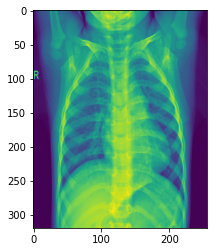

In [9]:
# testing mixup_tensorflow()
X, y = test_generator.next()
X, y = mixup_tensorflow(X, y)

# displaying the test image
test_index = np.random.randint(0, 16)
plt.imshow(np.reshape(X[test_index], newshape=(320, 256)))

# Implementing All Data Augmentation Methods

For every model that is trained, the only part of the training process that should be changing is the data augmentation. The rest of the training parameters, including the # of epochs and loss function, should remain the same for all models.

- Epochs: 75
- Optimizer: Adam
- Learning rate: 0.001
- Loss: binary crossentropy

## Creating a Res-Net 50 Model

In [10]:
# imports
import tensorflow as tf
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import add
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping

# create the model as a class
class ResNet:
  
  @staticmethod
  def residual_module(data, K, stride, chanDim, red=False, reg=0.0001, bnEps=2e-5, bnMom=0.9):
    # the shortcut branch of the ResNet module should be
    # initialize as the input (identity) data
    shortcut = data
    
    # the first block of the ResNet module are the 1x1 CONVs
    bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(data)
    act1 = Activation("relu")(bn1)
    conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False, kernel_regularizer=l2(reg))(act1)

    # the second block of the ResNet module are the 3x3 CONVs
    bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(conv1)
    act2 = Activation("relu")(bn2)
    conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride, padding="same", use_bias=False, kernel_regularizer=l2(reg))(act2)

    # the third block of the ResNet module is another set of 1x1 CONVs
    bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,momentum=bnMom)(conv2)
    act3 = Activation("relu")(bn3)
    conv3 = Conv2D(K, (1, 1), use_bias=False, kernel_regularizer=l2(reg))(act3)

    # if we are to reduce the spatial size, apply a CONV layer to the shortcut
    if red:
      shortcut = Conv2D(K, (1, 1), strides=stride, use_bias=False, kernel_regularizer=l2(reg))(act1)

    # add together the shortcut and the final CONV
    x = add([conv3, shortcut])

    # return the addition as the output of the ResNet module
    return x

  @staticmethod
  def build(width, height, depth, classes, stages, filters, reg=0.0001, bnEps=2e-5, bnMom=0.9):
    # initialize the input shape to be "channels last" and the channels dimension itself
    inputShape = (height, width, depth)
    chanDim = -1

    # if we are using "channels first", update the input shape and channels dimension
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
      chanDim = 1
    
    # set the input and apply BN
    inputs = Input(shape=inputShape)
    x = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(inputs)

    # apply CONV => BN => ACT => POOL to reduce spatial size
    x = Conv2D(filters[0], (5, 5), use_bias=False, padding="same", kernel_regularizer=l2(reg))(x)
    x = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(x)
    x = Activation("relu")(x)
    x = ZeroPadding2D((1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # loop over the number of stages
    for i in range(0, len(stages)):
      # initialize the stride, then apply a residual module used to reduce the spatial size of the input volume
      stride = (1, 1) if i == 0 else (2, 1)
      x = ResNet.residual_module(x, filters[i + 1], stride, chanDim, red=True, bnEps=bnEps, bnMom=bnMom)
    
    # loop over the number of layers in the stage
    for j in range(0, stages[i] - 1):
      # apply a ResNet module
      x = ResNet.residual_module(x, filters[i + 1], (1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)
    
    # apply BN => ACT => POOL
    x = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(x)
    x = Activation("relu")(x)
    x = AveragePooling2D((8, 8))(x)

    # softmax classifier
    x = Flatten()(x)
    x = Dense(1, kernel_regularizer=l2(reg))(x)
    x = Activation("sigmoid")(x)

    # create the model
    model = Model(inputs, x, name="resnet")

    # return constructed network architecture
    return model

Next, we need to build the model. We use the following parameters:

- 256 (image width)
- 320 (image height)
- 1 (depth) - meaning 1 channel (instead of 3, like RGB)
- 1 (classes) - use 1 class because labels are either 0 or 1, they are not one-hot encoded
- (3, 4, 6) - stages
- (64, 128, 256, 512) - convolution filters

To compile the model, we use the RMSProp optimizer with `binary_crossentropy` loss due to the nature of our classification task.

In [11]:
# building the model

model = ResNet.build(256, 320, 1, 1, (3, 4, 6), (64, 128, 256, 512))
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Below we can see a summary of our model.

In [12]:
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 320, 256, 1)  4          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 320, 256, 64  1600        ['batch_normalization[0][0]']    
                                )                                                            

## No Data Augmentation

In [ ]:
# fitting the model

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
)

history = model.fit(
    train_generator_no_aug,
    validation_data = test_generator_no_aug,
    epochs = 100,
    validation_steps=10,
    steps_per_epoch=50,
    callbacks=[es])

Epoch 1/75
50/50 [==============================] - 19s 313ms/step - loss: 1.1996 - accuracy: 0.3725 - val_loss: 1.1380 - val_accuracy: 0.4437
Epoch 2/75
50/50 [==============================] - 15s 298ms/step - loss: 1.0435 - accuracy: 0.6725 - val_loss: 1.1005 - val_accuracy: 0.6000
Epoch 3/75
50/50 [==============================] - 15s 298ms/step - loss: 0.9556 - accuracy: 0.7750 - val_loss: 1.0679 - val_accuracy: 0.6000
Epoch 4/75
50/50 [==============================] - 15s 297ms/step - loss: 0.9115 - accuracy: 0.7800 - val_loss: 1.0173 - val_accuracy: 0.6500
Epoch 5/75
50/50 [==============================] - 15s 296ms/step - loss: 0.8678 - accuracy: 0.7875 - val_loss: 1.0039 - val_accuracy: 0.6250
Epoch 6/75
50/50 [==============================] - 15s 297ms/step - loss: 0.8356 - accuracy: 0.8100 - val_loss: 0.9589 - val_accuracy: 0.6812
Epoch 7/75
50/50 [==============================] - 15s 295ms/step - loss: 0.8200 - accuracy: 0.8288 - val_loss: 0.9245 - val_accuracy: 0.7000

In [ ]:
# saving the model

# creating a dataframe of the model training history
history_df = pd.DataFrame(history.history)

# paths for saving model and training history
model_PATH = '/content/gdrive/MyDrive/Kaggle/chest_xray_data/chest_xray/models/final_results/resnet50_vanilla_results/seed_' + str(SEED) + '/model/'
history_PATH = '/content/gdrive/MyDrive/Kaggle/chest_xray_data/chest_xray/models/final_results/resnet50_vanilla_results/seed_' + str(SEED) + '/history/'

# saving the model and the training history
model.save(model_PATH)
history_df.to_csv(history_PATH + 'model_history.csv')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Kaggle/chest_xray_data/chest_xray/models/final_results/resnet50_vanilla_results/seed_333/model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


## Basic Data Augmentation

The difference between this model training process and the previous one is that the previous training uses `train_generator_no_aug`, which doesn't have any data augmentation, but this uses `train_generator`, which has data augmentation.

In [ ]:
# fitting the model

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
)

history = model.fit(
    train_generator,
    validation_data = test_generator_no_aug,
    epochs = 100,
    validation_steps=10,
    steps_per_epoch=50,
    callbacks=[es])

Epoch 1/75
50/50 [==============================] - 214s 4s/step - loss: 1.2421 - accuracy: 0.3450 - val_loss: 1.1430 - val_accuracy: 0.4875
Epoch 2/75
50/50 [==============================] - 153s 3s/step - loss: 1.0763 - accuracy: 0.6463 - val_loss: 1.1170 - val_accuracy: 0.6313
Epoch 3/75
50/50 [==============================] - 133s 3s/step - loss: 0.9953 - accuracy: 0.7513 - val_loss: 1.1173 - val_accuracy: 0.6438
Epoch 4/75
50/50 [==============================] - 111s 2s/step - loss: 0.9770 - accuracy: 0.7400 - val_loss: 1.0966 - val_accuracy: 0.6750
Epoch 5/75
50/50 [==============================] - 96s 2s/step - loss: 0.9532 - accuracy: 0.7275 - val_loss: 1.1116 - val_accuracy: 0.6250
Epoch 6/75
50/50 [==============================] - 82s 2s/step - loss: 0.9146 - accuracy: 0.7613 - val_loss: 1.0995 - val_accuracy: 0.6562
Epoch 7/75
50/50 [==============================] - 69s 1s/step - loss: 0.9009 - accuracy: 0.7487 - val_loss: 1.0513 - val_accuracy: 0.6562
Epoch 8/75
50/50

In [ ]:
# saving the model

# creating a dataframe of the model training history
history_df = pd.DataFrame(history.history)

# paths for saving model and training history
model_PATH = '/content/gdrive/MyDrive/Kaggle/chest_xray_data/chest_xray/models/final_results/resnet50_basic_augmentation_results/seed_' + str(SEED) + '/model/'
history_PATH = '/content/gdrive/MyDrive/Kaggle/chest_xray_data/chest_xray/models/final_results/resnet50_basic_augmentation_results/seed_' + str(SEED) + '/history/'

# saving the model and the training history
model.save(model_PATH)
history_df.to_csv(history_PATH + 'model_history.csv')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Kaggle/chest_xray_data/chest_xray/models/final_results/resnet50_basic_augmentation_results/seed_333/model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


## Mixup

For Mixup, the training process requires a TensorFlow training loop instead of a Keras `model.fit()` because the data augmentation occurrs at a lower level.

Additionally, we use `train_generator_no_aug` once again because the data augmentation is performed by the Mixup algorithm, not by the `ImageDataGenerator`.

In [ ]:
import time

# accuracy metrics
train_acc_metric = keras.metrics.BinaryAccuracy()
val_acc_metric = keras.metrics.BinaryAccuracy()

@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    logits = model(x, training=True)
    loss_value = loss_fn(y, logits)
  grads = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))
  train_acc_metric.update_state(y, logits)
  return loss_value

@tf.function
def test_step(x, y):
  val_logits = model(x, training=False)
  val_acc_metric.update_state(y, val_logits)

def train_model(model, loss_fn, optimizer, batch_size, 
                train_generator, epochs, test_generator):
  """Function for training the model using a TensorFlow training loop.

  Parameters:
      model (keras.engine.functional.Functional): model that will be trained
      loss_fn (tf.keras.losses): loss function that will be used when the
        model is being trained
      optimizer (tf.keras.optimizers): optimizer that will be used when the
        model is being trained
      batch_size (int): number that tells the function that size of each batch
      train_generator (tf.keras.preprocessing.image.DirectoryIterator): Image
        Data Generator that loads in batches of data for training
      epochs (int): number of epochs we want to train the model for
      test_generator (tf.keras.preprocessing.image.DirectoryIterator): Image
        Data Generator that loads in batches of data for validation
    
  Outputs:
      model (keras.engine.functional.Functional): trained model
  """

  # creating steps_per_epoch to determine when to 
  # break out of looping through the generator
  steps_per_epoch = ((train_generator.__len__()) // batch_size) + 1

  # creating val_steps_per_epcoh to determine when to
  # break out of looping through the generator
  val_steps_per_epoch = ((test_generator.__len__()) // batch_size) + 1

  # creating lists to keep track of train accuracy and val accuracy
  train_acc_list = []
  val_acc_list = []
  train_loss_list = []
  val_loss_list = []

  # looping through epochs
  for epoch in range(epochs):

    # displaying epoch number
    print("\nStart of epoch %d" % (epoch,))

    # used for calculating time
    start_time = time.time()

    # iterate over the batches of the dataset
    for i, (x_batch_train, y_batch_train) in enumerate(train_generator):

      # run through the VAE

      # altering the shape of labels to match shape of logits
      y_batch_train = np.reshape(y_batch_train, newshape=(y_batch_train.shape[0], 1))

      # generating a new batch
      x_batch_train, y_batch_train = mixup_tensorflow(x_batch_train, y_batch_train)

      # Open a GradientTape to record the operations run
      # during the forward pass, which enables auto-differentiation.
      with tf.GradientTape() as tape:

        # run `train_step`
        loss_value = train_step(x_batch_train, y_batch_train)

      # use the gradient tape to automatically retrieve
      # the gradients of the trainable variables with respect to the loss
      grads = tape.gradient(loss_value, model.trainable_weights)

      # run one step of gradient descent by updating
      # the value of the variables to minimize the loss
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

      # Log every 5 batches
      if i % 5 == 0:
        print("Training loss (for one batch) at step %d: %.4f" 
              % (i, float(loss_value)))
        print("Seen so far: %s samples" % ((i + 1) * batch_size))

      # break after going over steps_per_epoch 
      if i >= steps_per_epoch:
        break
    
    # display metrics at the end of each epoch
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # run a validation loop at the end of each epoch
    for j, (x_batch_val, y_batch_val) in enumerate(test_generator):

        # run `test_step` and update val_loss_value
        val_loss_value = test_step(x_batch_val, y_batch_val)

        # break after going over val_steps_per_epoch 
        if j >= val_steps_per_epoch:
          break
        
    # get result, reset state
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    
    # print val accuracy and time taken for entire epoch (train + val)
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))

    # keeping track of train/validation accuracy/loss
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(loss_value)
    val_loss_list.append(val_loss_value)
  
  # creating a df of train_acc_list and val_acc_list

  history_df = {
      'epochs': [],
      'train_acc': [],
      'train_loss': [],
      'val_acc': [],
      'val_loss': []
  }

  for i in range(epochs):
    history_df['epochs'].append(i + 1)
    history_df['train_acc'].append(train_acc_list[i])
    history_df['train_loss'].append(train_loss_list[i])
    history_df['val_acc'].append(val_acc_list[i])
    history_df['val_loss'].append(val_loss_list[i])

  history_df = pd.DataFrame(history_df)

  # returning the trained model
  return model, history_df

In [ ]:
# creating optimizer and loss_fn
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# calling the `train_model` function
trained_model, training_history = train_model(model=model, loss_fn=loss_fn, optimizer=optimizer, batch_size=16, train_generator=train_generator_no_aug, epochs=100, test_generator=test_generator)


Start of epoch 0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Training loss (for one batch) at step 0: 0.9477
Seen so far: 16 samples
Training loss (for one batch) at step 5: 0.8315
Seen so far: 96 samples
Training loss (for one batch) at step 10: 0.8935
Seen so far: 176 samples
Training loss (for one batch) at step 15: 0.7724
Seen so far: 256 samples
Training loss (for one batch) at step 20: 0.7039
Seen so far: 336 samples
Training acc over epoch: 0.3778
Validation acc: 0.5938
Time taken: 146.09s

Start of epoch 1
Training loss (for one batch) at step 0: 0.6881
Seen so far: 16 samples
Training loss (for one batch) at step 5: 0.6884
Seen so far: 96 samples
Training loss (for one batch) at step 10: 0.6054
Seen so far: 176 samples
Training loss (for one batch) at step 15: 0.5964
Seen so far: 256 samples
Training loss (for one batch) at step 20: 0.5435
Seen so far: 336 samples
Training acc over epoch: 0.6420
Validation acc: 0.6250
Time taken: 50.19s

Start of epoch 2
Training loss (for one batch) at step 0: 0.6765
Seen so far: 16 samples
Training lo

In [ ]:
# saving the model

# paths for saving model and training history
model_PATH = '/content/gdrive/MyDrive/Kaggle/chest_xray_data/chest_xray/models/final_results/resnet50_mixup_results/seed_' + str(SEED) + '/model/'
history_PATH = '/content/gdrive/MyDrive/Kaggle/chest_xray_data/chest_xray/models/final_results/resnet50_mixup_results/seed_' + str(SEED) + '/history/'

# saving the model and the training history
model.save(model_PATH)
training_history.to_csv(history_PATH + 'model_history.csv')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Kaggle/chest_xray_data/chest_xray/models/final_results/resnet50_mixup_results/seed_333/model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


## Mixup + VQ-VAE

The original plan was to use a basic VAE, but because the images are so large (320 by 256), the VAE could not produce high-quality reconstructions. So, I chose to switch to a VQ-VAE.

### Creating and Training the VQ-VAE

In [ ]:
# imports
!pip install -q tensorflow-probability
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf

In [ ]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = (
            beta  # This parameter is best kept between [0.25, 2] as per the paper.
        )

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = self.beta * tf.reduce_mean(
            (tf.stop_gradient(quantized) - x) ** 2
        )
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized, self.embeddings

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices


In [ ]:
# functions to create the encoder and decoder

def get_encoder(latent_dim=32):
    encoder_inputs = keras.Input(shape=(320, 256, 1))

    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)

    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=32):
    latent_inputs = keras.Input(shape=get_encoder().output.shape[1:])

    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(latent_inputs)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)

    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")


In [ ]:
# function to instantiate a vqvae

def get_vqvae(latent_dim=32, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(320, 256, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents, embeddings = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)

    return keras.Model(inputs, reconstructions, name="vq_vae")

get_vqvae().summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 320, 256, 1)]     0         
                                                                 
 encoder (Functional)        (None, 80, 64, 32)        20896     
                                                                 
 vector_quantizer (VectorQua  ((None, 80, 64, 32),     2048      
 ntizer)                      (32, 64))                          
                                                                 
 decoder (Functional)        (None, 320, 256, 1)       37249     
                                                                 
Total params: 60,193
Trainable params: 60,193
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def custom_sigmoid_cross_entropy_loss_with_logits(x_true, x_recons_logits):
    raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=x_true, logits=x_recons_logits)
    if len(np.shape(x_true))==4:
        neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3])
    else:
        neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1])
    return tf.math.reduce_mean(neg_log_likelihood)

In [ ]:
# VQVAE Trainer Class

class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            # NOTE - train_variance scales the loss given how spread out the data is
            # if variance is higher, we can forgive the model a bit more
            reconstruction_loss = (tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance)
            # reconstruction_loss = custom_sigmoid_cross_entropy_loss_with_logits(x, reconstructions)
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }


In [ ]:
# creating an x_train for VQVAE

from tqdm import tqdm

# creating an empty array
num_batches = 30
x = np.zeros((16 * num_batches, 320, 256, 1))

# adding to the array with batches of data
for i, (x_batch_train, y_batch_train) in tqdm(enumerate(train_generator_no_aug)):
  x[i:i + 16] = x_batch_train
  if i == num_batches:
    break
  
# finding data variance
data_variance = np.var(x)

# creating x_train
x_train = x

30it [01:39,  3.33s/it]


To optimize the VQ-VAE, I can change various parameters:


*   `latent_dim`
*   `num_embeddings`
*   `learning_rate`
*   the optimizer
*   `batch_size`
*   \# of epochs

In [ ]:
# training the VQVAE

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='reconstruction_loss', factor=0.6,
                              patience=3, min_lr=0.001)

vqvae_trainer = VQVAETrainer(data_variance, latent_dim=32, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01))
vqvae_trainer.fit(x_train, epochs=200, batch_size=128)

Epoch 1/200
4/4 [==============================] - 2s 295ms/step - loss: 1.1576 - reconstruction_loss: 1.0385 - vqvae_loss: 0.0379
Epoch 2/200
4/4 [==============================] - 1s 293ms/step - loss: 2.5516 - reconstruction_loss: 1.0059 - vqvae_loss: 1.3621
Epoch 3/200
4/4 [==============================] - 1s 292ms/step - loss: 17.1250 - reconstruction_loss: 1.0019 - vqvae_loss: 16.1606
Epoch 4/200
4/4 [==============================] - 1s 294ms/step - loss: 74.0630 - reconstruction_loss: 0.7607 - vqvae_loss: 73.2317
Epoch 5/200
4/4 [==============================] - 1s 292ms/step - loss: 284.9405 - reconstruction_loss: 2.0410 - vqvae_loss: 281.4892
Epoch 6/200
4/4 [==============================] - 1s 293ms/step - loss: 694.1816 - reconstruction_loss: 0.6464 - vqvae_loss: 693.5432
Epoch 7/200
4/4 [==============================] - 1s 294ms/step - loss: 454.6667 - reconstruction_loss: 0.7264 - vqvae_loss: 453.9266
Epoch 8/200
4/4 [==============================] - 1s 291ms/step - 

In [ ]:
# load random images to test the vqvae
test_images = test_generator.next()
test_X, test_y = test_images

# pass a test image into the trained vqvae
test_image = np.reshape(test_X[0], newshape=(1, 320, 256, 1))
reconstructed_image = trained_vqvae_model.predict(test_image)
reconstructed_image = np.reshape(reconstructed_image, (320, 256))

# display the reconstructed image and the label
plt.imshow(reconstructed_image, cmap="gray", vmin=0, vmax=1)

In [13]:
def plotcomparison(preds, actual, indices):
  fig = plt.figure(figsize=(25, 15))
  for i in range(16):
    if i%2==1:
      idx=indices[i//2]
      ax=plt.subplot(4, 4, i + 1)
      plt.imshow(np.squeeze(preds[i//2,:,:]), cmap="gray", vmin=0, vmax=1)
      plt.title("Reconstructed Image Example " + str(idx + 1), fontsize=20)
      plt.axis('off')
    else:
      idx=indices[i//2]
      plt.subplot(4, 4, i + 1)
      plt.imshow(np.squeeze(actual[i//2,:,:]), cmap="gray", vmin=0, vmax=1)
      plt.title("Original Image Example " + str(idx + 1), fontsize=20)
      plt.axis('off')

In [ ]:
tests = np.zeros((8, 320, 256, 1))
reconstructions = np.zeros((8, 320, 256, 1))

for i in range(8):
  test_image = np.reshape(test_X[i], newshape=(1, 320, 256, 1))
  reconstructed_image = trained_vqvae_model.predict(test_image)
  reconstructed_image = np.reshape(reconstructed_image, (320, 256, 1))
  test_image = np.reshape(test_image, newshape=(320, 256, 1))
  
  tests[i] = test_image
  reconstructions[i] = reconstructed_image

plotcomparison(reconstructions, tests, range(8))

(8, 320, 256, 1)
(8, 320, 256, 1)


In [ ]:
# separating the encoder, decoder, and vector quantizer
# select the trained encoder & decoder and the VectorQuantizer
trained_encoder_model = trained_vqvae_model.get_layer(name="encoder")
trained_decoder_model = trained_vqvae_model.get_layer(name="decoder")
trained_vector_quantizer = trained_vqvae_model.get_layer(name="vector_quantizer")

# saving the model
# trained_vqvae_model.save('/content/gdrive/MyDrive/Kaggle/chest_xray_data/chest_xray/models/final_results/vqvae_trained')

### Creating a function for VQ-VAE + Mixup

Given two batches of images, use the VQ-VAE and Mixup in the latent space to create a new batch of images. Choose a random Mixup `alpha` value to randomize the batch every time.

##### Loading in the VQ-VAE

In [ ]:
# loading in the trained model
trained_vqvae_model = keras.models.load_model('/content/gdrive/MyDrive/Kaggle/chest_xray_data/chest_xray/models/final_results/vqvae_trained')

# separating it into encoder, decoder, and vector quantizer
trained_encoder_model = trained_vqvae_model.get_layer(name="encoder")
trained_decoder_model = trained_vqvae_model.get_layer(name="decoder")
trained_vector_quantizer = trained_vqvae_model.get_layer(name="vector_quantizer")

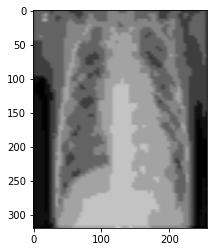

In [ ]:
# testing the trained vqvae

# loading test batch and creating selecting an image
X, y = test_generator.next()
img = np.reshape(X[np.random.randint(0, 16)], newshape=(1, 320, 256, 1))

# running the image through the VQ-VAE
encoder_outputs = trained_encoder_model(img)
vq_outputs, embeddings = trained_vector_quantizer(encoder_outputs)
reconstruction = trained_decoder_model(vq_outputs)

# converting reconstruction to a displayable np array
reconstruction = np.array(reconstruction)
reconstruction = np.reshape(reconstruction, newshape=(320, 256))

# displaying the image reconstructions
plt.imshow(reconstruction, cmap="gray", vmin=0, vmax=1)

##### VQ-VAE + Mixup function

In [ ]:
from PIL import Image

def vqvae_mixup(X1, y1, trained_encoder, trained_decoder, trained_vector_quantizer, data_set):
  """Given a batch of images, create a new batch with the same labels. 
  Then, use the VQ-VAE and Mixup in the latent space
  to create a new batch of images. Choose a random `alpha` value for Mixup to
  randomize the batch every time.

  Parameters:
    X1 (np.array): a numpy array of size (16, 320, 256, 1) that contains 16 images
    y1 (np.array): a numpy array of size (16, ) that contains the 16 labels for the images in the batch
    trained_encoder (Keras.model): a trained VQ-VAE encoder
    trained_decoder (Keras.model): a trained VQ-VAE decoder
    trained_vector_quantizer (Keras.model): a trained VQ-VAE vector quantizer
    data_set (str): determines if data set is train or test
  
  Returns:
    new_batch (np.array): a numpy array of size (16, 320, 256, 1) that contains 16 images
    y1 (np.array): a numpy array of size (16, ) that contains the 16 labels for the images in the batch
  """

  # finding batch size
  batch_size = X1.shape[0]

  # changing directory based on data_set parameter
  if data_set == 'train':
    os.chdir('/content/gdrive/MyDrive/Kaggle/chest_xray_data/chest_xray/train')
  elif data_set == 'test':
    os.chdir('/content/gdrive/MyDrive/Kaggle/chest_xray_data/chest_xray/test')

  # creating an empty array for the new batch
  next_batch = np.zeros((batch_size, 320, 256, 1))
  next_batch_labels = []

  # sampling random images and adding to the new batch
  i = 0

  for label in y1:

    if label == 1: # PNEUMONIA

      # open an image based on the data_set parameter
      if data_set == 'train':
        img = Image.open((train_path + '/PNEUMONIA/' + os.listdir(train_path + '/PNEUMONIA/')[np.random.randint(0, len(os.listdir()) - 1)]))
      elif data_set == 'test':
        img = Image.open((test_path + '/PNEUMONIA/' + os.listdir(test_path + '/PNEUMONIA/')[np.random.randint(0, len(os.listdir()) - 1)]))

      # resize the image, convert it to array, divide by 255, reshape into (x, y, 1)
      img = img.resize((256, 320))
      img = np.asarray(img)
      img = img / 255
      img = np.reshape(img, newshape=(img.shape[0], img.shape[1], 1))

      # add array of image to next_batch
      next_batch[i] = np.asarray(img)

    if label == 0: # NORMAL

      # open an image based on the data_set parameter
      if data_set == 'train':
        img = Image.open((train_path + '/NORMAL/' + os.listdir(train_path + '/NORMAL/')[np.random.randint(0, len(os.listdir()) - 1)]))
      elif data_set == 'test':
        img = Image.open((test_path + '/NORMAL/' + os.listdir(test_path + '/NORMAL/')[np.random.randint(0, len(os.listdir()) - 1)]))

      # resize the image, convert it to array, divide by 255, reshape into (x, y, 1)

      img = img.resize((256, 320))
      img = np.asarray(img)
      img = img / 255
      img = np.reshape(img, newshape=(img.shape[0], img.shape[1], 1))

      # add array of image to next_batch
      next_batch[i] = np.asarray(img)

    # incrementing i, adding labels
    i += 1
    next_batch_labels.append(label)

  # renaming next_batch
  X2 = np.array(next_batch)

  # creating array for new batch
  new_batch = np.zeros((batch_size, 320, 256, 1))

  count = 0

  for i in range(batch_size):

    # selecting both images
    img_1 = np.reshape(X1[i], newshape=(1, 320, 256, 1))
    img_2 = np.reshape(X2[i], newshape=(1, 320, 256, 1))

    num = np.random.random()

    if num > 0.5:

      # running VQVAE

      # running both through encoder
      encoder_outputs_1 = trained_encoder(img_1)
      encoder_outputs_2 = trained_encoder(img_2)

      # defining alpha
      alpha = np.random.beta(1.0, 1.0)

      # run encoder_ouputs through mixup
      newImage = (alpha * (encoder_outputs_1)) + ((1 - alpha) * (encoder_outputs_2))

      # running newImage through trained_vector_quantizer
      quantized_latents, embeddings = trained_vector_quantizer(newImage)

      # running quantized_latents through decoder
      reconstructions = trained_decoder(quantized_latents)

      # adding reconstructions to new_batch
      new_batch[i] = reconstructions
    
    else:

      if (num > 0.2):
        # alpha = np.random.beta(0.25, 0.25)
        # new_batch[i] = (alpha * (img_1)) + ((1 - alpha) * (img_2))
        new_batch[i] = img_1
      else:
        new_batch[i] = img_2

    count = i

  # returning new_batch
  return new_batch, y1

##### Testing the VQ-VAE + Mixup function

In [ ]:
def mixupcomparison(preds, indices):
    fig = plt.figure(figsize=(25, 15))
    for i in range(16):
      ax=plt.subplot(4, 4, i + 1)
      plt.imshow(np.squeeze(preds[i,:,:]), cmap="gray", vmin=0, vmax=1)
      plt.title("Reconstruction " + str(i), fontsize=20)
      plt.axis('off')

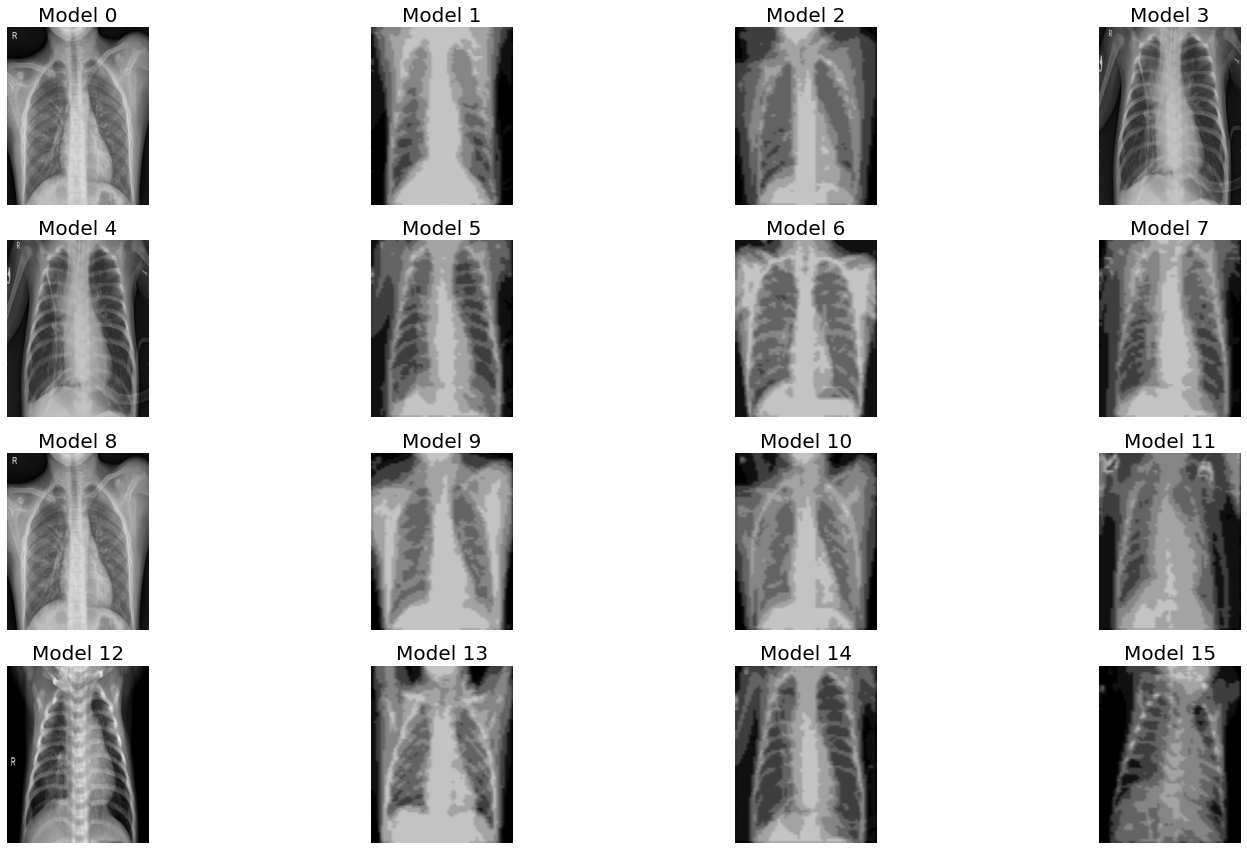

In [ ]:
batch_1 = test_generator_no_aug.next()
X, y = batch_1

# testing vqvae_mixup
new_batch, new_batch_labels = vqvae_mixup(X, 
                                          y, 
                                          trained_encoder_model,
                                          trained_decoder_model, 
                                          trained_vector_quantizer, 
                                          'test')

# displaying the new batch
mixupcomparison(new_batch, range(16))

### TF Training Loop + VQ-VAE + Mixup

In [ ]:
import time

# accuracy metrics
train_acc_metric = keras.metrics.BinaryAccuracy()
val_acc_metric = keras.metrics.BinaryAccuracy()

@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    logits = model(x, training=True)
    loss_value = loss_fn(y, logits)
  grads = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))
  train_acc_metric.update_state(y, logits)
  return loss_value

@tf.function
def test_step(x, y):
  val_logits = model(x, training=False)
  loss_value = loss_fn(y, val_logits)
  val_acc_metric.update_state(y, val_logits)
  return loss_value

def train_model_vqvae(model, loss_fn, optimizer, batch_size, 
                      train_generator, epochs, test_generator):
  """Function for training the model using a TensorFlow training loop.

  Parameters:
      model (keras.engine.functional.Functional): model that will be trained
      loss_fn (tf.keras.losses): loss function that will be used when the
        model is being trained
      optimizer (tf.keras.optimizers): optimizer that will be used when the
        model is being trained
      batch_size (int): number that tells the function that size of each batch
      train_generator (tf.keras.preprocessing.image.DirectoryIterator): Image
        Data Generator that loads in batches of data for training
      epochs (int): number of epochs we want to train the model for
      test_generator (tf.keras.preprocessing.image.DirectoryIterator): Image
        Data Generator that loads in batches of data for validation
    
  Outputs:
      model (keras.engine.functional.Functional): trained model
  """

  # creating steps_per_epoch to determine when to 
  # break out of looping through the generator
  steps_per_epoch = ((train_generator.__len__()) // batch_size) + 1

  # creating val_steps_per_epcoh to determine when to
  # break out of looping through the generator
  val_steps_per_epoch = ((test_generator.__len__()) // batch_size) + 1

  # creating lists to keep track of train accuracy and val accuracy
  train_acc_list = []
  val_acc_list = []
  train_loss_list = []
  val_loss_list = []

  # looping through epochs
  for epoch in range(epochs):

    # displaying epoch number
    print("\nStart of epoch %d" % (epoch,))

    # used for calculating time
    start_time = time.time()

    # iterate over the batches of the dataset
    for i, (x_batch_train, y_batch_train) in enumerate(train_generator):

      # run through the VAE

      # altering the shape of labels to match shape of logits
      y_batch_train = np.reshape(y_batch_train, newshape=(y_batch_train.shape[0], 1))

      # performing Mixup-VQ-VAE
      x_batch_train, y_batch_train = vqvae_mixup(x_batch_train, y_batch_train, trained_encoder_model, trained_decoder_model, trained_vector_quantizer, 'train')

      # altering y_batch_train again
      y_batch_train = np.reshape(y_batch_train, newshape=(len(y_batch_train), 1))

      # Open a GradientTape to record the operations run
      # during the forward pass, which enables auto-differentiation.
      with tf.GradientTape() as tape:

        # run `train_step`
        loss_value = train_step(x_batch_train, y_batch_train)

      # use the gradient tape to automatically retrieve
      # the gradients of the trainable variables with respect to the loss
      grads = tape.gradient(loss_value, model.trainable_weights)

      # run one step of gradient descent by updating
      # the value of the variables to minimize the loss
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

      # Log every 5 batches
      if i % 5 == 0:
        print("Training loss (for one batch) at step %d: %.4f" 
              % (i, float(loss_value)))
        print("Seen so far: %s samples" % ((i + 1) * batch_size))

      # break after going over steps_per_epoch 
      if i >= steps_per_epoch:
        break
    
    # display metrics at the end of each epoch
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # run a validation loop at the end of each epoch
    for j, (x_batch_val, y_batch_val) in enumerate(test_generator):

        # run `test_step` and update val_loss_value
        val_loss_value = test_step(x_batch_val, y_batch_val)

        # break after going over val_steps_per_epoch 
        if j >= val_steps_per_epoch:
          break
        
    # get result, reset state
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    
    # print val accuracy and time taken for entire epoch (train + val)
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))

    # keeping track of train/validation accuracy/loss
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(loss_value)
    val_loss_list.append(val_loss_value)
  
  # creating a df of train_acc_list and val_acc_list

  history_df = {
      'epochs': [],
      'train_acc': [],
      'train_loss': [],
      'val_acc': [],
      'val_loss': []
  }

  for i in range(epochs):
    history_df['epochs'].append(i + 1)
    history_df['train_acc'].append(train_acc_list[i])
    history_df['train_loss'].append(train_loss_list[i])
    history_df['val_acc'].append(val_acc_list[i])
    history_df['val_loss'].append(val_loss_list[i])

  history_df = pd.DataFrame(history_df)

  # returning the trained model
  return model, history_df

In [ ]:
# creating optimizer and loss_fn
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# calling the `train_model_vqvae` function
trained_model, training_history = train_model_vqvae(model=model, loss_fn=loss_fn, optimizer=optimizer, batch_size=16, train_generator=train_generator_no_aug, epochs=100, test_generator=test_generator)


Start of epoch 0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Training loss (for one batch) at step 0: 0.9345
Seen so far: 16 samples
Training loss (for one batch) at step 5: 2.1310
Seen so far: 96 samples
Training loss (for one batch) at step 10: 0.4598
Seen so far: 176 samples
Training loss (for one batch) at step 15: 0.7494
Seen so far: 256 samples
Training loss (for one batch) at step 20: 0.0592
Seen so far: 336 samples
Training acc over epoch: 0.7898
Validation acc: 0.6094
Time taken: 108.09s

Start of epoch 1
Training loss (for one batch) at step 0: 0.7846
Seen so far: 16 samples
Training loss (for one batch) at step 5: 0.1246
Seen so far: 96 samples
Training loss (for one batch) at step 10: 0.1366
Seen so far: 176 samples
Training loss (for one batch) at step 15: 0.6201
Seen so far: 256 samples
Training loss (for one batch) at step 20: 0.0755
Seen so far: 336 samples
Training acc over epoch: 0.9176
Validation acc: 0.7500
Time taken: 42.53s

Start of epoch 2
Training loss (for one batch) at step 0: 0.4609
Seen so far: 16 samples
Training lo

In [ ]:
# saving the model

# paths for saving model and training history
model_PATH = '/content/gdrive/MyDrive/Kaggle/chest_xray_data/chest_xray/models/final_results/resnet50_vqvae_mixup_results/seed_' + str(SEED) + '/model/'
history_PATH = '/content/gdrive/MyDrive/Kaggle/chest_xray_data/chest_xray/models/final_results/resnet50_vqvae_mixup_results/seed_' + str(SEED) + '/history/'

# saving the model and the training history
model.save(model_PATH)
training_history.to_csv(history_PATH + 'model_history.csv')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Kaggle/chest_xray_data/chest_xray/models/final_results/resnet50_vqvae_mixup_results/seed_333/model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


# Testing the Model with All Different Augmentation Methods

In [ ]:
# seed to load in
SEED = 333

# model and training history path
model_PATH = '/content/gdrive/MyDrive/Kaggle/chest_xray_data/chest_xray/models/final_results/resnet50_vanilla_results/seed_' + str(SEED) + '/model/'
history_PATH = '/content/gdrive/MyDrive/Kaggle/chest_xray_data/chest_xray/models/final_results/resnet50_vanilla_results/seed_' + str(SEED) + '/history/'

# loading the model
from tensorflow import keras
model = keras.models.load_model(model_PATH)

# loading results df
results_df = pd.read_csv(history_PATH + 'model_history.csv')

#### Making Predictions on the Test Set

In [ ]:
import random
from sklearn.utils import shuffle

# creating a list of images
num_images = len(os.listdir(test_path + '/PNEUMONIA/')) + len(os.listdir(test_path + '/NORMAL/'))

# creating an empty array for the new batch
images = np.zeros((num_images, 320, 256, 1))
labels = np.zeros(num_images)

# looping through num_images and adding to array
for i in range(num_images):
  
  if (i < 390):
    img = Image.open((test_path + '/PNEUMONIA/' + os.listdir(test_path + '/PNEUMONIA/')[i]))
    labels[i] = 1
  else:
    img = Image.open((test_path + '/NORMAL/' + os.listdir(test_path + '/NORMAL/')[i - 390]))
    labels[i] = 0

  # resize the image, convert it to array, divide by 255, reshape into (x, y, 1)
  img = img.resize((256, 320))
  img = np.asarray(img)
  img = img / 255
  img = np.reshape(img, newshape=(img.shape[0], img.shape[1], 1))

  # add array of image to next_batch
  images[i] = np.asarray(img)
  
# shuffling the images
images, labels = shuffle(images, labels, random_state=0)

In [ ]:
# making predictions and calculating accuracy

preds = []

for i in range(len(images)):
  preds.append(model.predict(np.reshape(images[i], newshape=(1, 320, 256, 1))))

correct_count = 0
total_count = 0

for i in range(len(preds)):

  if (preds[i] >= 0.5):
    preds[i] = 1
  else:
    preds[i] = 0

  if (preds[i] == labels[i]):
    correct_count += 1
  total_count += 1

print(correct_count / total_count)

0.6410256410256411


In [ ]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

seed_111_acc = accuracy_score(labels, preds)
seed_111_pre = precision_score(labels, preds)
seed_111_rec = recall_score(labels, preds)
seed_111_f1 = f1_score(labels, preds)

In [ ]:
seed_222_acc = accuracy_score(labels, preds)
seed_222_pre = precision_score(labels, preds)
seed_222_rec = recall_score(labels, preds)
seed_222_f1 = f1_score(labels, preds)

In [ ]:
seed_333_acc = accuracy_score(labels, preds)
seed_333_pre = precision_score(labels, preds)
seed_333_rec = recall_score(labels, preds)
seed_333_f1 = f1_score(labels, preds)

In [ ]:
acc_arr = np.array([seed_111_acc, seed_222_acc, seed_333_acc])
pre_arr = np.array([seed_111_pre, seed_222_pre, seed_333_pre])
rec_arr = np.array([seed_111_rec, seed_222_rec, seed_333_rec])
f1_arr = np.array([seed_111_f1, seed_222_f1, seed_333_f1])

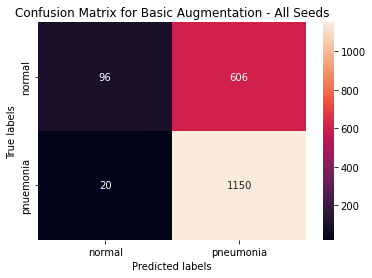

In [ ]:
ax = plt.subplot()
sns.heatmap(all_seeds_confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for Basic Augmentation - All Seeds'); 
ax.xaxis.set_ticklabels(['normal', 'pneumonia']); ax.yaxis.set_ticklabels(['normal', 'pnuemonia']);

#### Plotting Validation Accuracy and Loss Over Time

In [ ]:
# plotting the validation accuracy over time

# changing plot style
plt.style.use('ggplot')

# plt subplots
fig, ax = plt.subplots()

fig.set_figwidth(15)
fig.set_figheight(5)

# creating an array to hold the validation accuracy values over time
val_acc = np.zeros((len(results_df)))
for i in range(len(results_df)):
  val_acc[i] = float(results_df['val_acc'][i][10:14]) * 100
  # val_acc[i] = results_df['val_accuracy'][i] * 100

# annotating the maximum validation accuracy on the graph
def annot_max(x, y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "Max Val Accuracy: Epoch {:}, Val Acc: {:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.5", fc="w", ec="k", lw=0.72)
    arrowprops = dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data', textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)
    
annot_max(range(1, len(val_acc) + 1), val_acc)

# plotting the validation accuracy
ax.set_ylim(0, 100)
ax.set_title("Validation Accuracy Over Time", fontsize=18)
ax.set_xlabel("Epochs", fontsize=15)
ax.set_ylabel("Prediction Accuracy (%)", fontsize=15)
ax.plot(val_acc)

# increasing font size of xticks and yticks
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
  label.set_fontsize(12)
  label.set_fontweight('bold')

In [ ]:
# plotting the validation accuracy over time

# changing plot style
plt.style.use('ggplot')

# plt subplots
fig, ax = plt.subplots()

fig.set_figwidth(15)
fig.set_figheight(5)

# creating an array to hold the validation accuracy values over time
val_loss = np.zeros((len(results_df)))
for i in range(len(results_df)):
  val_loss[i] = float(results_df['val_loss'][i][10:14])
  # val_loss[i] = results_df['val_loss'][i]

# annotating the maximum validation accuracy on the graph
def annot_max(x, y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "Max Val Accuracy: Epoch {:}, Val Acc: {:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.5", fc="w", ec="k", lw=0.72)
    arrowprops = dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data', textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)
    
# annot_max(range(1, 76), val_loss)

# plotting the validation accuracy
ax.set_ylim(0, max(val_loss) + 0.1)
ax.set_title("Validation Loss Over Time", fontsize=18)
ax.set_xlabel("Epochs", fontsize=15)
ax.set_ylabel("Prediction Loss", fontsize=15)
ax.plot(val_loss)

# increasing font size of xticks and yticks
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
  label.set_fontsize(12)
  label.set_fontweight('bold')

#### Creating Classification Report

In [ ]:
# printing metrics
from sklearn.metrics import classification_report

print(classification_report(preds, labels))

              precision    recall  f1-score   support

           0       0.53      0.94      0.68       132
           1       0.98      0.78      0.87       492

    accuracy                           0.81       624
   macro avg       0.75      0.86      0.77       624
weighted avg       0.88      0.81      0.83       624

